In [1]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tqdm import tqdm
from sklearn.feature_selection import SelectKBest, f_classif


memuat 2164 images


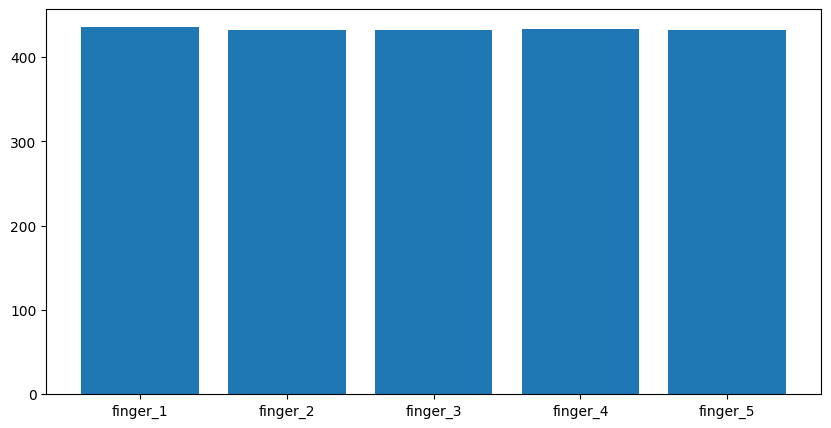

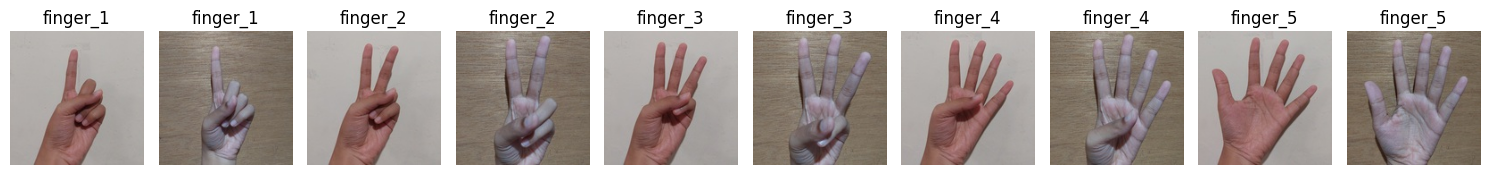

In [2]:
def loadingimg(folders):
    target_size = (150, 150)
    images = []
    labels = []
    count = {folder: 0 for folder in folders}
    samples = {folder: [] for folder in folders}
    for folder in folders:
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = cv.imread(img_path)
            if img is not None:
                img = cv.resize(img, target_size)
                images.append(img)
                labels.append(os.path.basename(folder))
                count[folder] += 1
                if len(samples[folder]) < 2:
                    samples[folder].append(img)
    return images, labels, count, samples
finger1 = 'finger_1'
finger2 = 'finger_2'
finger3 = 'finger_3'
finger4 = 'finger_4'
finger5 = 'finger_5'

images, labels, count, sample = loadingimg([finger1, finger2, finger3, finger4, finger5])


print(f"memuat {len(images)} images")

plt.figure(figsize=(10, 5))
plt.bar(count.keys(), count.values())
plt.show()


fig, axs = plt.subplots(1, len([finger1, finger2, finger3, finger4, finger5]) * 2, figsize=(15, 5))
axs = axs.flatten()
for i, folder_path in enumerate([finger1, finger2, finger3, finger4, finger5]):
    folder_name = os.path.basename(folder_path)
    for j in range(2):
        index = i * 2 + j
        if j < len(sample[folder_name]):
            axs[index].imshow(cv.cvtColor(sample[folder_name][j], cv.COLOR_BGR2RGB))
            axs[index].set_title(f"{folder_name}")   
        axs[index].axis('off')

plt.tight_layout()
plt.show()


## Data Loading

## Data Preparation

### Data Augmentation

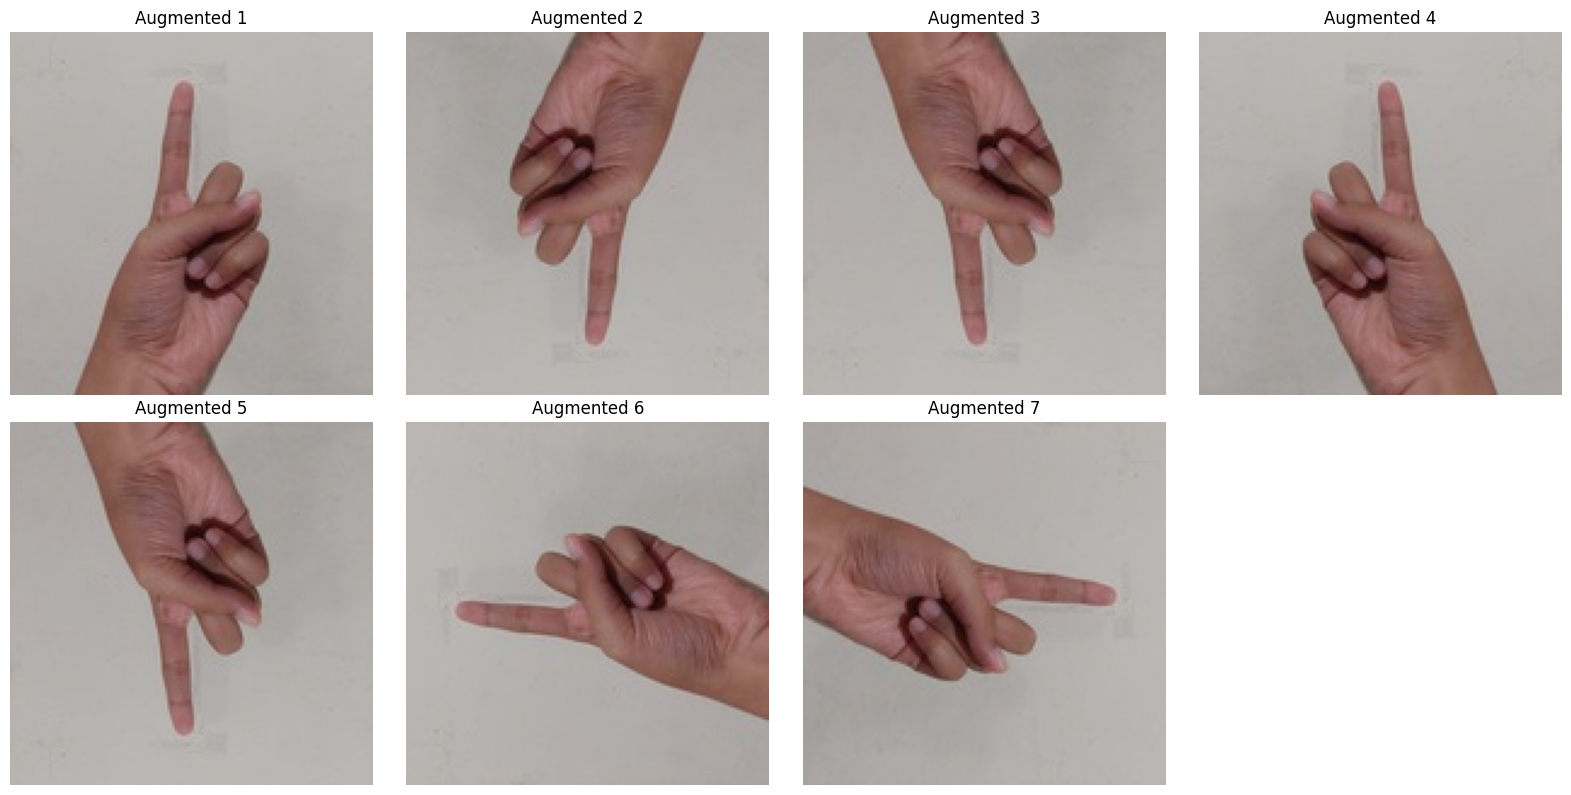

In [3]:
def augmentation(images):
    augmented_images = []
    for img in images:
        augmented_images.append(img)
        augmented_img_1 = cv.rotate(img, cv.ROTATE_180)
        augmented_images.append(augmented_img_1)
        augmented_img_2 = cv.flip(augmented_img_1, 1)
        augmented_images.append(augmented_img_2)
        augmented_img_3 = cv.flip(img, 1)
        augmented_images.append(augmented_img_3)
        augmented_img_4 = cv.flip(img, 0)
        augmented_images.append(augmented_img_4)
        augmented_img_5 = cv.rotate(img, cv.ROTATE_90_COUNTERCLOCKWISE)
        augmented_images.append(augmented_img_5)
        augmented_img_6 = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)
        augmented_images.append(augmented_img_6)

    return augmented_images
contoh = augmentation([img for img, label in zip(images, labels) if label == finger1])

plt.figure(figsize=(16, 8))
for i, img in enumerate(contoh):
    if i >= 7: 
        break
    plt.subplot(2, 4, i + 1)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(f"Augmented {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

augmentasi1 = augmentation([img for img, label in zip(images, labels) if label == finger1])
augmentasi2 = augmentation([img for img, label in zip(images, labels) if label == finger2])
augmentasi3 = augmentation([img for img, label in zip(images, labels) if label == finger3])
augmentasi4 = augmentation([img for img, label in zip(images, labels) if label == finger4])
augmentasi5 = augmentation([img for img, label in zip(images, labels) if label == finger5])



### Preprocessing

#### Preprocessing 2

In [4]:
def grayscale(image):
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    return gray_image
def threshold(image):
   for i in range(image.shape[0]):
      for j in range(image.shape[1]):
         if image[i][j] < 128:
            image[i][j] = 0
         if image[i][j] >= 128:
            image[i][j] = 255
   return image
def pre_processing(images):
    preproses = []
    for img in images:
        grayed_img = grayscale(img)
        threshold_image = threshold(grayed_img)
        preproses.append(threshold_image)
    return preproses

preproses1 = pre_processing(augmentasi1)
preproses2 = pre_processing(augmentasi2)
preproses3 = pre_processing(augmentasi3)
preproses4 = pre_processing(augmentasi4)
preproses5 = pre_processing(augmentasi5)

### Feature Extraction

In [5]:
def derajat0(img):
    max = np.max(img)
    temp = np.zeros([max + 1, max + 1])
    
    for i in range(len(img)):
        for j in range(len(img[i]) - 1):
            temp[img[i, j], img[i, j + 1]] += 1
    
    data = temp + temp.T
    data /= np.sum(data)
    
    return data

In [6]:

def derajat45(img):
    max = np.max(img)
    temp = np.zeros([max + 1, max + 1])
    
    for i in range(len(img) - 1):
        for j in range(len(img[i]) - 1):
            temp[img[i + 1, j], img[i, j + 1]] += 1
    
    data = temp + temp.T
    data /= np.sum(data)
    
    return data

In [7]:

def derajat90(img):
    max = np.max(img)
    temp = np.zeros([max + 1, max + 1])
    
    for i in range(len(img) - 1):
        for j in range(len(img[i]) - 1):
            temp[img[i + 1, j], img[i, j]] += 1
    
    data = temp + temp.T
    data /= np.sum(data)
    
    return data

In [8]:

def derajat135(img):
    max = np.max(img)
    temp = np.zeros([max + 1, max + 1])
    
    for i in range(len(img) - 1):
        for j in range(len(img[i]) - 1):
            temp[img[i, j], img[i + 1, j + 1]] += 1
    
    data = temp + temp.T
    data /= np.sum(data)
    
    return data


In [9]:
def gabung(image):
    features = []
    
    for img in image:
        data = []
        data.append(derajat0(img))
        data.append(derajat45(img))
        data.append(derajat90(img))
        data.append(derajat135(img))
        features.append(data)
        
    return features

In [10]:
def kontras(data):
    return sum([x * pow(i - j, 2) for i, row in enumerate(data) for j, x in enumerate(row)])


In [11]:

def dissimilarity(data):
    return sum([abs(i - j) * x for i, row in enumerate(data) for j, x in enumerate(row)])


In [12]:

def homogenitas(data):
    return sum([x / (1 + pow(i - j, 2)) for i, row in enumerate(data) for j, x in enumerate(row)])


In [13]:

def entropy(data):
    return -sum([x * math.log(x) for row in data for x in row if x > 0.0])


In [14]:

def asm(data):
    return sum([x ** 2 for row in data for x in row])


In [15]:

def energy(data):
    return sum([x ** 2 for row in data for x in row])


In [16]:
def korelasi(data):
    jumlahBaris = len(data)
    jumlahKolom = len(data[0])
    sumIJ = sum(i * j * data[i][j] for i in range(jumlahBaris) for j in range(jumlahKolom))
    sumI = sum(i * data[i][j] for i in range(jumlahBaris) for j in range(jumlahKolom))
    sumJ = sum(j * data[i][j] for i in range(jumlahBaris) for j in range(jumlahKolom))
    sumI_squared = sum((i - sumI) ** 2 * data[i][j] for i in range(jumlahBaris) for j in range(jumlahKolom))
    sumJ_squared = sum((j - sumJ) ** 2 * data[i][j] for i in range(jumlahBaris) for j in range(jumlahKolom))

    std_i = math.sqrt(sumI_squared)
    std_j = math.sqrt(sumJ_squared)

    if std_i != 0 and std_j != 0:
        kor = (sumIJ - sumI * sumJ) / (std_i * std_j)
    else:
        kor = 0

    return kor

In [17]:
output_dir = 'csv_percobaann_2'
os.makedirs(output_dir, exist_ok=True)

def ekstraksi(data, label):
    features = gabung(data)
    data = []
    angles = ['0', '45', '90', '135']
    result = []
    n = 100

    for j in tqdm(range(min(len(features), n)), desc=f'Ekstraksi fitur untuk {label}'):
        eksfitur = [label]

        for i in features[j]:
            co = kontras(i)
            eksfitur.append(co)
            di = dissimilarity(i)
            eksfitur.append(di)
            ho = homogenitas(i)
            eksfitur.append(ho)
            ent = entropy(i)
            eksfitur.append(ent)
            asmV = asm(i)
            eksfitur.append(asmV)
            en = energy(i)
            eksfitur.append(en)
            ko = korelasi(i)
            eksfitur.append(ko)

        result.append(eksfitur)

    headers = ['path']
    for angle in angles:
        headers.extend([f'kontras{angle}', f'dissimilarity{angle}', f'homogenitas{angle}', f'entropi{angle}', f'asm{angle}', f'energi{angle}', f'correlation{angle}'])

    df = pd.DataFrame(result, columns=headers)

    df.to_csv(os.path.join(output_dir, f'percobaan_ke_1_{label}.csv'), index=False)
    return df

glcm1 = ekstraksi(preproses1, 'finger_1')
glcm2 = ekstraksi(preproses2, 'finger_2')
glcm3 = ekstraksi(preproses3, 'finger_3')
glcm4 = ekstraksi(preproses4, 'finger_4')
glcm5 = ekstraksi(preproses5, 'finger_5')


Ekstraksi fitur untuk finger_5: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


In [18]:

def bersihkan_data(df):
    df_cleaned = df.loc[:, (df != df.iloc[0]).any()]
    return df_cleaned
def seleksi_fitur(df, k=10):
    y = df['path']
    df_cleaned = bersihkan_data(df.drop(columns=['path']))
    
    X = df_cleaned
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    
    mask = selector.get_support()
    selected_features = X.columns[mask]
    
    df_selected = pd.DataFrame(X_new, columns=selected_features)
    df_selected['path'] = y.reset_index(drop=True)
    
    print(f"Fitur yang dipilih untuk {df_selected['path'][0]}:")
    print(df_selected.head())
    
    return df_selected

df_selected_finger1 = seleksi_fitur(glcm1, k=10)
df_selected_finger2 = seleksi_fitur(glcm2, k=10)
df_selected_finger3 = seleksi_fitur(glcm3, k=10)
df_selected_finger4 = seleksi_fitur(glcm4, k=10)
df_selected_finger5 = seleksi_fitur(glcm5, k=10)


Fitur yang dipilih untuk finger_1:
      asm90  energi90  correlation90   kontras135  dissimilarity135  \
0  0.646657  0.646657       0.956253  1912.586145          7.500338   
1  0.646657  0.646657       0.956253  1912.586145          7.500338   
2  0.646657  0.646657       0.956253  1467.389982          5.754471   
3  0.646657  0.646657       0.956253  1467.389982          5.754471   
4  0.646657  0.646657       0.956253  1467.389982          5.754471   

   homogenitas135  entropi135    asm135  energi135  correlation135      path  
0        0.970587    0.648617  0.632709   0.632709        0.913170  finger_1  
1        0.970587    0.648617  0.632709   0.632709        0.913170  finger_1  
2        0.977434    0.625209  0.639199   0.639199        0.933382  finger_1  
3        0.977434    0.625209  0.639199   0.639199        0.933382  finger_1  
4        0.977434    0.625209  0.639199   0.639199        0.933382  finger_1  
Fitur yang dipilih untuk finger_2:
      asm90  energi90  correl

c:\Users\rizki\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
c:\Users\rizki\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
c:\Users\rizki\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
c:\Users\rizki\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)
c:\Users\rizki\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:108: RuntimeWarning: invalid value encounter